## 聚类与统计策略分析


In [22]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

## 导入数据

In [23]:
raw = pd.read_csv('data.csv',index_col=0, parse_dates=True).dropna()
symbol = 'EUR='
data = pd.DataFrame(raw[symbol])
data['returns'] = np.log(data / data.shift(1))
data.dropna(inplace=True)
data['direction'] = np.sign(data['returns']).astype(int)

In [24]:
lags = 2
def create_lags(data):
    global cols
    cols = []
    for lag in range(1,lags+1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)
create_lags(data)
data.dropna(inplace=True)
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984


## 聚类分析
- 1.对特征数据进行聚类操作，使用Kmeans,K=2来完成
- 2.将聚类结果划分成-1,1两种类别
- 3.试试水，看看效果

In [25]:
from sklearn.cluster import KMeans

In [26]:
model = KMeans(n_clusters = 2)

In [27]:
data[cols].head()

,lag_1,lag_2
Date,,
2010-01-07,0.003058,-0.002988
2010-01-08,-0.006544,0.003058
2010-01-11,0.006544,-0.006544
2010-01-12,0.006984,0.006544
2010-01-13,-0.001310,0.006984


In [28]:
model.fit(data[cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
data['pos_clus'] = model.predict(data[cols])

In [30]:
data['pos_clus'] = np.where(data['pos_clus'] == 1,1,-1)

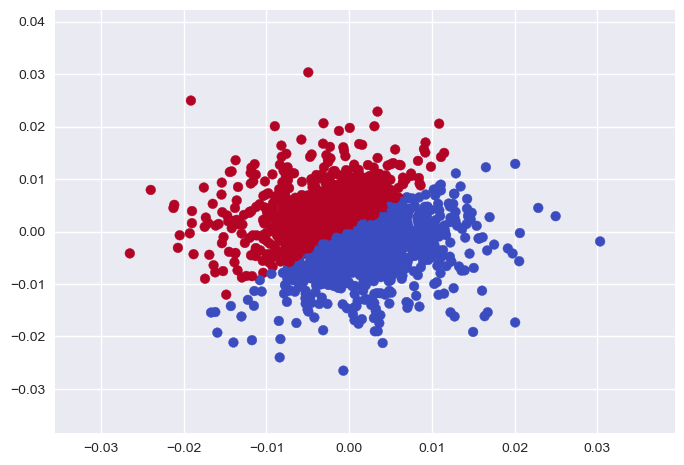

In [31]:
plt.scatter(data[cols].iloc[:,0],data[cols].iloc[:,1],c=data['pos_clus'],cmap='coolwarm')

In [32]:
data['clus_rets'] = data['pos_clus'] * data['returns']

In [33]:
data[['returns','clus_rets']].sum().apply(np.exp)

returns      0.810644
clus_rets    1.288282
dtype: float64

## 统计分析
- 1.分别统计前两天，前一天的数据情况，并将结果划分成两个区间
- 2.使用groupby来观察分组情况
- 3.设计策略；来试试水

In [34]:
def create_bins(data,bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col +'_bin'
        data[col_bin] = np.digitize(data[col],bins = bins)
        cols_bin.append(col_bin)
create_bins(data)

In [35]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin
Date,,
2010-01-07,1,0
2010-01-08,0,1
2010-01-11,1,0
2010-01-12,1,1
2010-01-13,0,1


In [36]:
grouped = data.groupby(cols_bin + ['direction'])

In [37]:
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           239
                       0             4
                       1           258
           1          -1           262
                       1           288
1          0          -1           272
                       0             1
                       1           278
           1          -1           278
                       0             4
                       1           251
dtype: int64

In [38]:
res = grouped['direction'].size().unstack(fill_value = 0)

In [39]:
grouped['direction'].size().unstack(fill_value = 0)

direction             -1   0    1
lag_1_bin lag_2_bin              
0         0          239   4  258
          1          262   0  288
1         0          272   1  278
          1          278   4  251

In [40]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2,-1,1)

In [41]:
(data['direction'] == data['pos_freq']).value_counts()

True     1102
False    1033
dtype: int64

In [42]:
data['freq_rets'] = data['pos_freq'] * data['returns']
data[['returns','freq_rets']].sum().apply(np.exp)

returns      0.810644
freq_rets    0.989513
dtype: float64